In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

%matplotlib inline

from pydrake.all import (SignalLogger, CompliantMaterial, ConstantVectorSource, DirectCollocation, DiagramBuilder, FloatingBaseType,
                         PiecewisePolynomial, RigidBodyTree, RigidBodyPlant,
                         SolutionResult, AddModelInstancesFromSdfString,
                         MathematicalProgram, Simulator, BasicVector, AddFlatTerrainToWorld)
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

In [34]:
# set the initial state

x = 0.0
z = 0.0

x_dot = 1.0
z_dot = 10.0

thetay = 2.0

# state of the flywheel
phi = 0.0
phi_dot = 0.0

torque = -0.0

# time of simulation (number of seconds)
time_of_sim = 2.0


state_initial = (x,0.,z,0.,thetay,0.,phi,x_dot,0.,z_dot,0.,0.,0.,phi_dot)

Num states: 14
Spawning PlanarRigidBodyVisualizer for tree with 1 actuators


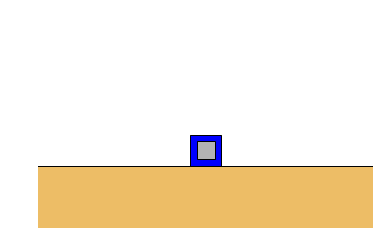

In [40]:
timestep = 0.0
builder = DiagramBuilder()
tree = RigidBodyTree(FindResource("cubli/cubli.urdf"),
                     FloatingBaseType.kFixed)
plant = RigidBodyPlant(tree, timestep)
nx = tree.get_num_positions() + tree.get_num_velocities()
print("Num states: {}".format(nx))

allmaterials = CompliantMaterial()
allmaterials.set_youngs_modulus(1E9) # default 1E9
allmaterials.set_dissipation(1.0) # default 0.32
allmaterials.set_friction(1.0) # default 0.9.
plant.set_default_compliant_material(allmaterials)

plant_context = plant.CreateDefaultContext()

robot = builder.AddSystem(plant)

torque_system = builder.AddSystem(ConstantVectorSource(
    np.ones((tree.get_num_actuators(), 1))*torque))
builder.Connect(torque_system.get_output_port(0),
                robot.get_input_port(0))

# what do xlim and ylim mean, what about -5 for the ground element
vis = builder.AddSystem(PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-1, 2.5]))
builder.Connect(robot.get_output_port(0),
                vis.get_input_port(0))

# And also log
signalLogRate = 60
signalLogger = builder.AddSystem(SignalLogger(nx))
signalLogger._DeclarePeriodicPublish(1. / signalLogRate, 0.0)
builder.Connect(robot.get_output_port(0),
                signalLogger.get_input_port(0))

diagram = builder.Build()

simulator = Simulator(diagram)
simulator.set_target_realtime_rate(0.25)
simulator.set_publish_every_time_step(False)

In [41]:
context = simulator.get_mutable_context()
state = context.get_mutable_state().get_mutable_continuous_state().get_mutable_vector()
state.SetFromVector(state_initial)
simulator.StepTo(time_of_sim)

In [42]:
ani = vis.animate(signalLogger, repeat=True)
HTML(ani.to_html5_video())

In [43]:
def contact_check(state):
    return True

In [88]:
def cube_dynamics(state, u):
    '''
    Calculates the dynamics of the cubli system

    :param state: numpy array, length 14, comprising state of system:
        [x, y, z, thetax, thetay, thetaz, theta, etc.]
    :param u: numpy array, length 1, comprising control input for system:
        [\ddot{theta}]   
        Note that this is only the added acceleration, note the total acceleration.

    :return: numpy array, length 14, comprising the time derivative of the system state:
        [\dot{x}, \dot{y}, etc.]

    '''
    
    # Need to grab important parameters
    M = 1.0 # self.M
    I_cube = 1.0 #self.I_cube
    I_wheel = 1.0 #self.I_wheel
    g = 9.81 # self.g
    
    # Relevant states are x,z,thetay, phi
    x = state[0]
    z = state[2]
    thetay = state[4]
    phi = state[6]
    
    xdot = state[7]
    zdot = state[9]
    thetaydot = state[11]
    phidot = state[13]
    
    # Setup the derivative of the state vector
    derivs = np.zeros_like(state)
    derivs[0:7] = state[7:]
    
    # Need to detect which set of dynamics to use
    contact = contact_check(state)
    
    if(contact):
        # Dynamics while the block is on the ground
        derivs[7] = 0.0 # Force balance in x, friction etc.  
        derivs[9] = 0.0 # Force balance in z, normal force 
        derivs[11] = -u[0]/I_wheel # Moment balance around center of block 
        derivs[13] = u[0]/I_wheel # Torque on the inertia wheel

    else:
        # Ballistic Dynamics
        
        derivs[7] = 0.0 # No forces along x
        derivs[9] = -g  # Acceleration due to gravity
        derivs[11] = -u[0]/I_wheel # Back torque due to wheel
        derivs[13] = u[0]/I_wheel # Wheel inertia
        
    return derivs     

In [92]:
def compute_optimal_control(initial_state,final_state, min_time, max_time):
    # solve for the trajectory and input I wish to achieve
    mp = MathematicalProgram()

    # number knot points
    N = 50
    
    # Total time used
    time_used = mp.NewContinuousVariables(1, "time_used") # add random variabe for time used

    dt = time_used/(N+1)

    u = mp.NewContinuousVariables(1, "u_%d" % 0) # only one input for the cube
    u_over_time = u

    for k in range(1,N):
        u = mp.NewContinuousVariables(1, "u_%d" % k)
        u_over_time = np.vstack((u_over_time, u))
    total_u = u_over_time

    # create x variables
    x = mp.NewContinuousVariables(14, "x_%d" % 0) # for both input thrusters
    x_over_time = x
    for k in range(1,N+1):
        x = mp.NewContinuousVariables(14, "x_%d" % k)
        x_over_time = np.vstack((x_over_time, x))
    total_x = x_over_time

    # State Constraints
    error_thresh = 0.001
    for n in range(N):
        # Actual state vs. predicted (through dynamics) state
        state_next = total_x[n+1]
        dynamic_state_next = total_x[n,:] + cube_dynamics(total_x[n,:], total_u[n,:])*dt
        
        # Make sure the actual and predicted align to follow dynamics
        for j in range(14):
            state_error = state_next[j] - dynamic_state_next[j]
            mp.AddConstraint(state_error <= error_thresh)
            mp.AddConstraint(state_error >= -error_thresh)


    # Quadratic Cost in control effort
    mp.AddQuadraticCost(1 * u_over_time[:,0].dot(u_over_time[:,0]))

    # Add initial state constraint
    for i in range(14):
        initial_state_error = x_over_time[0,i] - initial_state[i]
        mp.AddConstraint(initial_state_error == 0.0)

    
    # Add final state constraint
    for i in range(14):
        final_state_error = x_over_time[-1,i] - final_state[i]
        mp.AddConstraint(final_state_error == 0.0)

        
    # add time constraint
    mp.AddConstraint(time_used[0] >= minimum_time)
    mp.AddConstraint(time_used[0] <= maximum_time)

    print "Number of decision vars", mp.num_vars()
    print(mp.Solve())

    trajectory = mp.GetSolution(x_over_time)
    input_trajectory = mp.GetSolution(u_over_time)
    t = mp.GetSolution(time_used)
    time_array = np.arange(0.0, t, t/(N+1))
    
    return trajectory, input_trajectory, time_array

In [93]:
def plot_xy(trajectory):
    cube_x = trajectory[:,0] 
    cube_y = trajectory[:,1]
    
    fig, axes = plt.subplots(nrows=1,ncols=1)
    axes.plot(cube_x, cube_y)
    axes.axis("equal")
    
    plt.show()

In [91]:
# set some initial conditions and parameters
x = 0.; z = 0.; thetay = 0.; phi = 0.; 
x_dot = 0.; z_dot = 0.; thetay_dot = 0.; phi_dot = 0.;
state_initial = (x,0.,z,0.,thetay,0.,phi,x_dot,0.,z_dot,0.,thetay_dot,0.,phi_dot)

state_final = ()
minimum_time = 5.
maximum_time = 15.

traj, input_traj, time_array = compute_optimal_control(state_initial, minimum_time, maximum_time)

plot_xy(traj)


NameError: global name 'perp_error' is not defined